In [9]:
#!/usr/bin/python
#encoding:utf-8

"""
@author: LlQ
@contact:LIQINGLIN54951@gmail.com
@file：ipFreeProxyDotCZ.py
@time: 9/13/2019 3:10 AM
"""

#Under the Anaconda Prompt
#pip install fake-useragent
from fake_useragent import UserAgent
from selenium import webdriver
from lxml import etree
import pandas as pd
import re
import numpy as np
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import time
import json

In [10]:
domainList=["http://free-proxy.cz"]
domain = domainList[0]
base="/en/proxylist/main/1"
#print(domain+base)

#####responding to anti-crawler
userAgent=UserAgent()
#print(userAgent.random)
#Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_2) AppleWebKit/537.17 (KHTML, like Gecko) Chrome/24.0.1309.0 Safari/537.17
#The actual userAgent
# (right click your mouse then select Inspection
# and then you can find it from Headers by clicking any elementName Under the Name in Network )
header = {'UserAgent':"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.100 Safari/537.36",
          'Connection':'close'#countryNameRaw
         }
#print(header['UserAgent'])
#Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.100 Safari/537.36

options = webdriver.ChromeOptions()
options.add_argument("'user-agent=" + header['UserAgent'] + "'")
options.add_argument('--diable-gpu') # google document mentioned this attribute can avoid some bugs
options.add_experimental_option('excludeSwitches',['enable-automation'])
#set the browser as developer model, prevent the website identifying that you are using Selenium
#browser = webdriver.Chrome(executable_path='D:/chromedriver/chromedriver',
#                           chrome_options=options)
#run command("window.navigator.webdriver")in the Console of the inspection
#result: undefine  # means: regular browser

In [11]:
class GetIp():
    def __init__(self, domain=domain, baseUrl=base):
        self.domain = domain
        self.url = self.domain + str(baseUrl)
        self.browser = webdriver.Chrome(executable_path='D:/chromedriver/chromedriver',
                                        chrome_options=options
                                        )
        from selenium.webdriver.support.ui import WebDriverWait
        self.wait = WebDriverWait(self.browser, 2)

    def __del__(self):
        
        #self.browser.close()  # close current browser's window or tab
        self.browser.quit() #close browser  
    
    def get_webpagecontent(self):
        print(self.url)
        
        #import requests
        #Python requests appear "HTTPConnectionPool Max retires exceeded"
        #requests.session().keep_alive=False
        #requests.adapters.DEFAULT_RETRIES = 5
        
        self.browser.keep_alive=False
        self.browser.DEFAULT_RETRIES = 5
        
        self.browser.get(self.url)
        
        #from selenium.webdriver.support import expected_conditions as EC
        #from selenium.webdriver.common.by import By
        self.wait.until(EC.presence_of_element_located((By.ID, "proxy_list")))
        pageSource = self.browser.page_source
        return pageSource
    
    def parse_webData(self, pageSource):
        #get ip Data and save it into a dataframe
        df = pd.read_html(pageSource, header=0)[1]
        # print(df)
        # import re
        selector = etree.HTML(pageSource)
        countryDict = {}
        #locate to the selection box on webpage
        time.sleep(.5)
        countryNameRaw = selector.xpath('//select/option/text()')
        #get country name's Abbreviation
        countryAbbreviations = selector.xpath('//select/option/@value')
        
        #create a dictionary{countryName:countryAbbreviations}
        for i in range(2, len(countryNameRaw)):
            #get country name
            countryName = re.findall('[\u4e00-\u9fa5_a-zA-Z]+', countryNameRaw[i])[0]
            #create a dictionary{countryName:countryAbbreviations}
            countryDict[countryName] = countryAbbreviations[i]
                    
        for r in range(df.shape[0]):
            #get Ip Address
            ipAddress = re.findall(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b', df.loc[r, 'IP address'])
            
            if len(ipAddress) == 0:
                df.drop([r], inplace=True) #drop the row in which there not exist ip data
            else:
                df.loc[r, 'IP address'] = ipAddress[0]
                #get Port
                port = re.findall(r'\b[0-9]+\b', str(df.loc[r, 'Port']))[0]
                df.loc[r, 'Port'] = port

                if df.loc[r, 'Country'] in countryDict.keys():
                    #countryName, countryAbbreviations      #United States, US                               
                    df.loc[r, 'Country'] = df.loc[r, 'Country']+", "+countryDict[df.loc[r, 'Country']]

                # import numpy as np
                if pd.isnull(df.loc[r, 'Region']) and pd.isnull(df.loc[r, 'City']):
                    # df.loc[r,'Region']=np.nan#pd.NaT
                    # df.loc[r,'City']=np.nan#pd.NaT
                    df.loc[r, 'Location'] = np.nan
                elif pd.isnull(df.loc[r, 'Region']) and pd.isnull(df.loc[r, 'City']) == False:
                    df.loc[r, 'Location'] = df.loc[r, 'City']
                elif pd.isnull(df.loc[r, 'Region']) == False and pd.isnull(df.loc[r, 'City']):
                    df.loc[r, 'Location'] = df.loc[r, 'Region']
                else:
                    df.loc[r, 'Location'] = df.loc[r, 'Region'] + ", " + df.loc[r, 'City']

        df.drop(['Region', 'City'], axis=1, inplace=True)

        df.columns = ['IP Address', 'Port', 'Protocol', 'Country', 'Anonymity',
                      'Speed', 'Available', 'Response Time', 'Update', 'Location']            
        return df, countryDict # main page ip data and country Dict
    
    def crawler(self, pageNumber=0):  # get first 3 pages' data
        #current page
        #pageNumber = 0
        
        pageSource = self.get_webpagecontent()
        ipDataFrame,countryDict = self.parse_webData(pageSource)
        # print(ipDataFrame)
        
        hasNextPage = False
        # from lxml import etree
        selector = etree.HTML(pageSource)
        try:
            time.sleep(.5)
            # nextPageUrl = selector.xpath('//div[@class="pagination"]/a[contains(text(),"Next »")]/@href')[0]
            nextPageUrl = selector.xpath('//div[@class="paginator"]/a[last()]/@href')[0]
            if nextPageUrl:
                hasNextPage = True
        except:
            #print("No next page!")
            return ipDataFrame

        while hasNextPage and pageNumber < 2:
            self.url = self.domain + nextPageUrl
            pageSource = self.get_webpagecontent()
            pageNumber = pageNumber + 1
            ###
            currentIpDataFrame, countryDict = self.parse_webData(pageSource)
            #combine two dataframe
            ipDataFrame = pd.concat([ipDataFrame, currentIpDataFrame])
            
            
            hasNextPage = False
            selector = etree.HTML(pageSource)
            try:
                # nextPageUrl = selector.xpath('//div[@class="pagination"]/a[contains(text(),"Next »")]/@href')[0]
                nextPageUrl = selector.xpath('//div[@class="paginator"]/a[last()]/@href')[0]
                if nextPageUrl:
                    hasNextPage = True
            except:
                break

        return ipDataFrame
    
    def execute2(self):  # get at most (first) 5 pages's data for each value on selection('country')
        pageSource = self.get_webpagecontent()
        self.browser.implicitly_wait(2)

        selector = etree.HTML(pageSource)
        # get all values belonging to select tag
        countryAbbreviations = selector.xpath('//select/option/@value')
        # print(countryAbbreviations)

        from selenium.webdriver.support.select import Select
        # from selenium.webdriver.common.action_chains import ActionChains #import mouse action event package
        from time import sleep

        selectionBox = self.browser.find_element_by_id('frmsearchFilter-country')

        # Select(selectionBox).select_by_value("BT")
        # Select(selectionBox).select_by_value("MO")
        # ipCrawler.browser.find_element_by_name("send").click()

        counterCountry = 0
        ipDataFrame = None  # create a empty dataframe
        for value in countryAbbreviations:
            if value != 'all' and counterCountry < 5:
                Select(selectionBox).select_by_value(value)
                self.browser.find_element_by_name("send").click()

                self.url = self.browser.current_url  # reset url since each page's url is different
                if ipDataFrame is None:
                    ipDataFrame = self.crawler()
                else:
                    ipDataFrame = ipDataFrame.append(self.crawler(), ignore_index=True)
                sleep(2)
                counterCountry = counterCountry + 1

                # since each page's select tag is a instance
                selectionBox = self.browser.find_element_by_id('frmsearchFilter-country')
        self.browser.quit()  # close browser
        return ipDataFrame
    
    def execute(self, country='all', protocol='all',anonymity='all'):  # get at most (first) 5 pages's data for each value on selection('country')
        pageSource = self.get_webpagecontent()
        self.browser.implicitly_wait(2)

        selector = etree.HTML(pageSource)
        # get all values belonging to select tag
        countryAbbreviations = selector.xpath('//select/option/@value')
        # print(countryAbbreviations)

        from selenium.webdriver.support.select import Select
        # from selenium.webdriver.common.action_chains import ActionChains #import mouse action event package
        import time
        time.sleep(.5)

        selectionBox = self.browser.find_element_by_id('frmsearchFilter-country')          
        Select(selectionBox).select_by_value(country)
        
        protocolButton = self.browser.find_element_by_xpath( '//input[@value="{}"]'.format(protocol) )
        protocolButton.click()
        
        anonymityButton = self.browser.find_element_by_xpath( '//input[@value="{}"]'.format(anonymity) )
        anonymityButton.click()
        #Filter proxies
        self.browser.find_element_by_name("send").click()

        self.url = self.browser.current_url  # reset url since each page's url is different
        ipDataFrame = self.crawler()

        self.browser.quit()  # close browser
        return ipDataFrame
    
    def ipData_to_file(self, fileName, ipDataFrame):
        import json
        import sys
        #set the column "IP Address" as the index of dataframe 
        #and I will use this index as key of a dict 
        ipDataFrame.set_index('IP Address', inplace=True)
        
        #convert dataframe to json string            #since the dataframe is not using ascii
        ipJsonStr=ipDataFrame.to_json(orient='index', force_ascii = False)  #type: str
        #convert json string to json dict
        ipJsonDict=json.loads(ipJsonStr) #type: dict
        #save dict to a file            #sys.stdout.encoding=='utf-8' since my system using utf-8
        with open(fileName,'w',encoding=sys.stdout.encoding) as f:
            ipDataDF = json.dump(ipJsonDict,f, ensure_ascii=False)
            f.write('\n')
            
    def getIpData_from_file(self, fileName):
        with open(fileName, 'r', encoding='utf-8') as f:
            ipJsonDict = json.load(f)
        return ipJsonDict
    
    def getSpecifedIpList_from_nestedJsonDict(self, jsonDict,innerKey,innerValue):
        return [k for k,v in jsonDict.items() if v[innerKey]==innerValue]

# 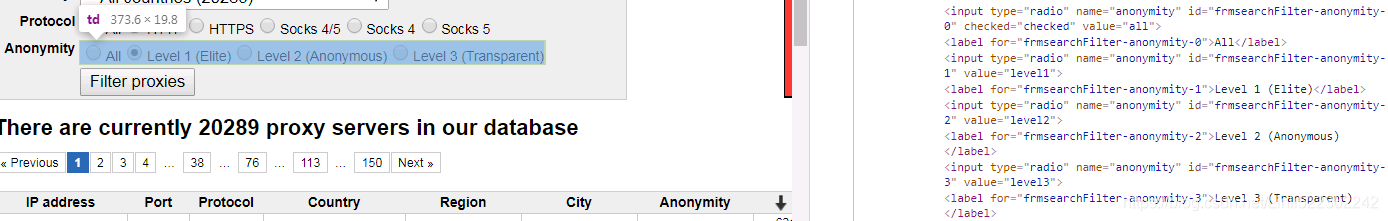

In [12]:
ipCrawler=GetIp(domain,base)
#level1:High  #level2:Anonymous #level3:Transparent
ipDataFrame=ipCrawler.execute(country='CN',protocol='http',anonymity='level1')
ipDataFrame

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: use options instead of chrome_options
  


http://free-proxy.cz/en/proxylist/main/1
http://free-proxy.cz/en/proxylist/country/CN/http/ping/level1
http://free-proxy.cz/en/proxylist/country/CN/http/ping/level1/2
http://free-proxy.cz/en/proxylist/country/CN/http/ping/level1/3


,IP Address,Port,Protocol,Country,Anonymity,Speed,Available,Response Time,Update,Location
0,111.29.3.194,8080,HTTP,"China, CN",High anonymity,NaN,89.7%,963 ms,6 hours ago,"Hainan, Qionghai"
1,111.29.3.191,80,HTTP,"China, CN",High anonymity,NaN,100%,966 ms,9 hours ago,"Hainan, Qionghai"
2,183.234.241.105,8118,HTTP,"China, CN",High anonymity,NaN,82.7%,1009 ms,9 hours ago,"Guangdong, Shenzhen"
3,111.29.3.223,80,HTTP,"China, CN",High anonymity,NaN,100%,1030 ms,8 hours ago,"Hainan, Qionghai"
5,111.29.3.184,8080,HTTP,"China, CN",High anonymity,NaN,94.9%,1042 ms,10 hours ago,"Hainan, Qionghai"
6,117.90.5.226,9000,HTTP,"China, CN",High anonymity,NaN,12.5%,1047 ms,13 hours ago,"Jiangsu, Nanjing"
7,125.123.122.114,9999,HTTP,"China, CN",High anonymity,NaN,NaN,1080 ms,8 hours ago,"Zhejiang, Jiaxing"
8,222.66.94.130,80,HTTP,"China, CN",High anonymity,NaN,97.5%,1080 ms,6 hours ago,"Shanghai, Shanghai"
9,117.93.133.157,61234,HTTP,"China, CN",High anonymity,NaN,63.2%,1088 ms,11 hours ago,"Jiangsu, Nanjing"
10,27.203.240.203,8060,HTTP,"China, CN",High anonymity,NaN,NaN,1097 ms,13 hours ago,"Shandong, Jinan"


Write ip data to file

In [13]:
ipCrawler.ipData_to_file('ipDataFrame.txt',ipDataFrame)

# 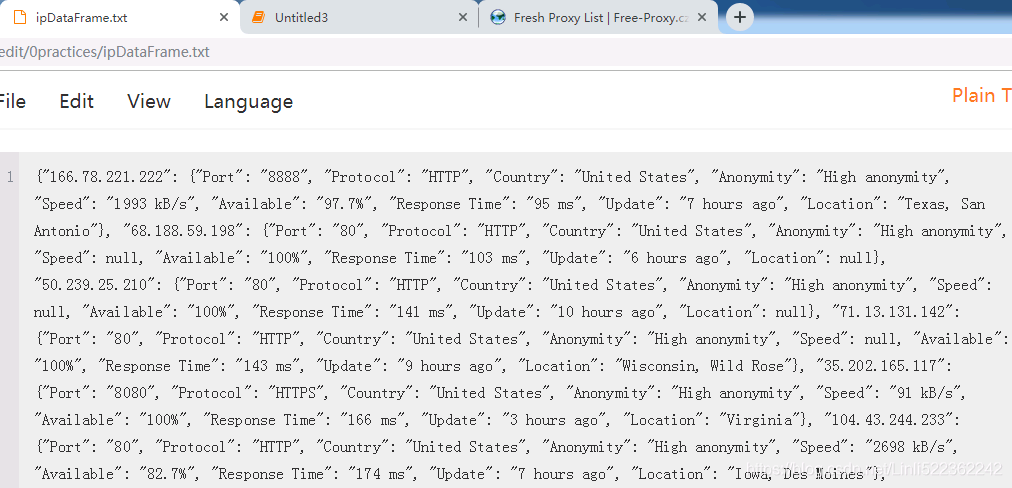

Read ip data from specified file and save them in a nested dict

In [14]:
ipDataDict=ipCrawler.getIpData_from_file('ipDataFrame.txt')
ipDataDict

{'111.29.3.194': {'Port': '8080',
  'Protocol': 'HTTP',
  'Country': 'China, CN',
  'Anonymity': 'High anonymity',
  'Speed': None,
  'Available': '89.7%',
  'Response Time': '963 ms',
  'Update': '6 hours ago',
  'Location': 'Hainan, Qionghai'},
 '111.29.3.191': {'Port': '80',
  'Protocol': 'HTTP',
  'Country': 'China, CN',
  'Anonymity': 'High anonymity',
  'Speed': None,
  'Available': '100%',
  'Response Time': '966 ms',
  'Update': '9 hours ago',
  'Location': 'Hainan, Qionghai'},
 '183.234.241.105': {'Port': '8118',
  'Protocol': 'HTTP',
  'Country': 'China, CN',
  'Anonymity': 'High anonymity',
  'Speed': None,
  'Available': '82.7%',
  'Response Time': '1009 ms',
  'Update': '9 hours ago',
  'Location': 'Guangdong, Shenzhen'},
 '111.29.3.223': {'Port': '80',
  'Protocol': 'HTTP',
  'Country': 'China, CN',
  'Anonymity': 'High anonymity',
  'Speed': None,
  'Available': '100%',
  'Response Time': '1030 ms',
  'Update': '8 hours ago',
  'Location': 'Hainan, Qionghai'},
 '111.29.3

In [15]:
import pprint #for print dict structure
pprint.pprint(ipDataDict)

{'1.197.204.61': {'Anonymity': 'High anonymity',
                  'Available': '4.1%',
                  'Country': 'China, CN',
                  'Location': 'Henan, Zhengzhou',
                  'Port': '9999',
                  'Protocol': 'HTTP',
                  'Response Time': '1837 ms',
                  'Speed': None,
                  'Update': '10 hours ago'},
 '101.231.104.82': {'Anonymity': 'High anonymity',
                    'Available': '99.1%',
                    'Country': 'China, CN',
                    'Location': 'Shanghai, Shanghai',
                    'Port': '80',
                    'Protocol': 'HTTP',
                    'Response Time': '1499 ms',
                    'Speed': None,
                    'Update': '8 hours ago'},
 '101.27.23.45': {'Anonymity': 'High anonymity',
                  'Available': '50%',
                  'Country': 'China, CN',
                  'Location': 'Hebei, Hebei',
                  'Port': '61234',
                  'P

 '150.109.60.185': {'Anonymity': 'High anonymity',
                    'Available': '86.7%',
                    'Country': 'China, CN',
                    'Location': 'Beijing, Beijing',
                    'Port': '8888',
                    'Protocol': 'HTTP',
                    'Response Time': '1494 ms',
                    'Speed': None,
                    'Update': '7 hours ago'},
 '171.35.168.227': {'Anonymity': 'High anonymity',
                    'Available': None,
                    'Country': 'China, CN',
                    'Location': 'Jiangxi, Nanchang',
                    'Port': '9999',
                    'Protocol': 'HTTP',
                    'Response Time': '1782 ms',
                    'Speed': None,
                    'Update': '7 hours ago'},
 '171.35.171.38': {'Anonymity': 'High anonymity',
                   'Available': None,
                   'Country': 'China, CN',
                   'Location': 'Jiangxi, Nanchang',
                   'Port': '999

In [ ]:
# get the detail by a specifed ip addresss

ipDataDict['104.152.45.45']  #get ip detatil by a specifed ip addresss

# 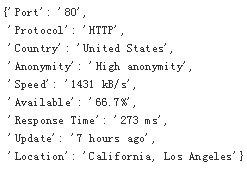

# get an ip list by specifed location
ipList=ipCrawler.getSpecifedIpList_from_nestedJsonDict(ipDataDict,'Location','California, Los Angeles')
ipList

# 

# Convert the nested dict to a dataframe

In [18]:
import pandas as pd
dataframe = pd.DataFrame(ipDataDict)
dataframe

,1.197.204.61,101.231.104.82,101.27.23.45,110.243.21.55,110.243.23.5,110.243.5.41,111.29.3.184,111.29.3.185,111.29.3.187,111.29.3.191,...,47.103.40.244,47.106.140.89,47.106.216.42,47.107.175.190,58.253.152.216,58.253.159.143,59.33.69.52,60.183.14.54,60.186.228.93,60.220.200.152
Anonymity,High anonymity,High anonymity,High anonymity,High anonymity,High anonymity,High anonymity,High anonymity,High anonymity,High anonymity,High anonymity,...,High anonymity,High anonymity,High anonymity,High anonymity,High anonymity,High anonymity,High anonymity,High anonymity,High anonymity,High anonymity
Available,4.1%,99.1%,50%,None,None,14.3%,94.9%,95.9%,100%,100%,...,None,93.8%,54.2%,66.1%,1.4%,11.1%,None,None,None,66.3%
Country,"China, CN","China, CN","China, CN","China, CN","China, CN","China, CN","China, CN","China, CN","China, CN","China, CN",...,"China, CN","China, CN","China, CN","China, CN","China, CN","China, CN","China, CN","China, CN","China, CN","China, CN"
Location,"Henan, Zhengzhou","Shanghai, Shanghai","Hebei, Hebei","Hebei, Hebei","Hebei, Hebei","Hebei, Hebei","Hainan, Qionghai","Hainan, Qionghai","Hainan, Qionghai","Hainan, Qionghai",...,"Zhejiang, Hangzhou","Zhejiang, Hangzhou","Zhejiang, Hangzhou","Zhejiang, Hangzhou","Guangdong, Guangzhou","Guangdong, Guangzhou","Guangdong, Guangzhou","Zhejiang, Shaoxing","Zhejiang, Hangzhou","Shanxi, Taiyuan"
Port,9999,80,61234,9999,9999,9999,8080,8080,80,80,...,8080,8080,8000,8000,9999,9999,61234,61234,8060,8060
Protocol,HTTP,HTTP,HTTP,HTTP,HTTP,HTTP,HTTP,HTTP,HTTP,HTTP,...,HTTP,HTTP,HTTP,HTTP,HTTP,HTTP,HTTP,HTTP,HTTP,HTTP
Response Time,1837 ms,1499 ms,1842 ms,1769 ms,1782 ms,1428 ms,1042 ms,1155 ms,1114 ms,966 ms,...,1547 ms,1463 ms,1116 ms,1157 ms,1524 ms,1838 ms,1579 ms,1909 ms,1769 ms,1316 ms
Speed,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Update,10 hours ago,8 hours ago,8 hours ago,13 hours ago,7 hours ago,13 hours ago,10 hours ago,12 hours ago,12 hours ago,9 hours ago,...,8 hours ago,14 hours ago,10 hours ago,11 hours ago,12 hours ago,9 hours ago,13 hours ago,9 hours ago,11 hours ago,11 hours ago


gives a name to the row which the columnName on

In [19]:
dataframe.columns.name="IP Address"
dataframe

IP Address,1.197.204.61,101.231.104.82,101.27.23.45,110.243.21.55,110.243.23.5,110.243.5.41,111.29.3.184,111.29.3.185,111.29.3.187,111.29.3.191,...,47.103.40.244,47.106.140.89,47.106.216.42,47.107.175.190,58.253.152.216,58.253.159.143,59.33.69.52,60.183.14.54,60.186.228.93,60.220.200.152
Anonymity,High anonymity,High anonymity,High anonymity,High anonymity,High anonymity,High anonymity,High anonymity,High anonymity,High anonymity,High anonymity,...,High anonymity,High anonymity,High anonymity,High anonymity,High anonymity,High anonymity,High anonymity,High anonymity,High anonymity,High anonymity
Available,4.1%,99.1%,50%,None,None,14.3%,94.9%,95.9%,100%,100%,...,None,93.8%,54.2%,66.1%,1.4%,11.1%,None,None,None,66.3%
Country,"China, CN","China, CN","China, CN","China, CN","China, CN","China, CN","China, CN","China, CN","China, CN","China, CN",...,"China, CN","China, CN","China, CN","China, CN","China, CN","China, CN","China, CN","China, CN","China, CN","China, CN"
Location,"Henan, Zhengzhou","Shanghai, Shanghai","Hebei, Hebei","Hebei, Hebei","Hebei, Hebei","Hebei, Hebei","Hainan, Qionghai","Hainan, Qionghai","Hainan, Qionghai","Hainan, Qionghai",...,"Zhejiang, Hangzhou","Zhejiang, Hangzhou","Zhejiang, Hangzhou","Zhejiang, Hangzhou","Guangdong, Guangzhou","Guangdong, Guangzhou","Guangdong, Guangzhou","Zhejiang, Shaoxing","Zhejiang, Hangzhou","Shanxi, Taiyuan"
Port,9999,80,61234,9999,9999,9999,8080,8080,80,80,...,8080,8080,8000,8000,9999,9999,61234,61234,8060,8060
Protocol,HTTP,HTTP,HTTP,HTTP,HTTP,HTTP,HTTP,HTTP,HTTP,HTTP,...,HTTP,HTTP,HTTP,HTTP,HTTP,HTTP,HTTP,HTTP,HTTP,HTTP
Response Time,1837 ms,1499 ms,1842 ms,1769 ms,1782 ms,1428 ms,1042 ms,1155 ms,1114 ms,966 ms,...,1547 ms,1463 ms,1116 ms,1157 ms,1524 ms,1838 ms,1579 ms,1909 ms,1769 ms,1316 ms
Speed,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Update,10 hours ago,8 hours ago,8 hours ago,13 hours ago,7 hours ago,13 hours ago,10 hours ago,12 hours ago,12 hours ago,9 hours ago,...,8 hours ago,14 hours ago,10 hours ago,11 hours ago,12 hours ago,9 hours ago,13 hours ago,9 hours ago,11 hours ago,11 hours ago


current dataframe does transpose

In [20]:
import copy
ipDataframe=copy.deepcopy(dataframe.T)
ipDataframe[:5]

,Anonymity,Available,Country,Location,Port,Protocol,Response Time,Speed,Update
IP Address,,,,,,,,,
1.197.204.61,High anonymity,4.1%,"China, CN","Henan, Zhengzhou",9999,HTTP,1837 ms,None,10 hours ago
101.231.104.82,High anonymity,99.1%,"China, CN","Shanghai, Shanghai",80,HTTP,1499 ms,None,8 hours ago
101.27.23.45,High anonymity,50%,"China, CN","Hebei, Hebei",61234,HTTP,1842 ms,None,8 hours ago
110.243.21.55,High anonymity,None,"China, CN","Hebei, Hebei",9999,HTTP,1769 ms,None,13 hours ago
110.243.23.5,High anonymity,None,"China, CN","Hebei, Hebei",9999,HTTP,1782 ms,None,7 hours ago


extract the numerical value and rename the columnName of dataframe

In [25]:
#ipDataframe.columns= ['Port', 'Protocol', 'Country', 'Anonymity',
#                      'Speed(KB/s)', 'Available', 'Response(ms)', 'Update(hours ago)', 'Location']

for ip in ipDataframe.index:
    speed = re.findall( '[0-9]+', str(ipDataframe.loc[ip,'Speed']) )
    if len(speed)!=0:
        ipDataframe.loc[ip,'Speed'] = int(speed[0])
    else:     
        ipDataframe.loc[ip,'Speed']=np.nan

    response = re.findall( '[0-9]+', str(ipDataframe.loc[ip,'Response Time']) )
    if len(response)!=0:
        ipDataframe.loc[ip,'Response Time'] = int(response[0])
    else:     
        ipDataframe.loc[ip,'Response Time']=np.nan
        
    update = re.findall( '[0-9]+', str(ipDataframe.loc[ip,'Update']) )
    if len(update)!=0:
        ipDataframe.loc[ip,'Update'] = int(update[0])
    else:     
        ipDataframe.loc[ip,'Update']=np.nan    
ipDataframe.columns= [ 'Anonymity','Available', 'Country', 'Location', 'Port', 'Protocol',
                       'Response(ms)','Speed(KB/s)', 'Update(hours ago)']
columnOrder= [ 'Port','Protocol','Anonymity','Available', 'Country', 'Location',
                       'Response(ms)','Speed(KB/s)', 'Update(hours ago)']
ipDataframe=ipDataframe[columnOrder]
ipDataframe[:10]

,Port,Protocol,Anonymity,Available,Country,Location,Response(ms),Speed(KB/s),Update(hours ago)
IP Address,,,,,,,,,
1.197.204.61,9999,HTTP,High anonymity,4.1%,"China, CN","Henan, Zhengzhou",1837,NaN,10
101.231.104.82,80,HTTP,High anonymity,99.1%,"China, CN","Shanghai, Shanghai",1499,NaN,8
101.27.23.45,61234,HTTP,High anonymity,50%,"China, CN","Hebei, Hebei",1842,NaN,8
110.243.21.55,9999,HTTP,High anonymity,None,"China, CN","Hebei, Hebei",1769,NaN,13
110.243.23.5,9999,HTTP,High anonymity,None,"China, CN","Hebei, Hebei",1782,NaN,7
110.243.5.41,9999,HTTP,High anonymity,14.3%,"China, CN","Hebei, Hebei",1428,NaN,13
111.29.3.184,8080,HTTP,High anonymity,94.9%,"China, CN","Hainan, Qionghai",1042,NaN,10
111.29.3.185,8080,HTTP,High anonymity,95.9%,"China, CN","Hainan, Qionghai",1155,NaN,12
111.29.3.187,80,HTTP,High anonymity,100%,"China, CN","Hainan, Qionghai",1114,NaN,12


sort the dataframe

In [26]:
ipDataframe=ipDataframe.sort_values(by=['Speed(KB/s)'],ascending=False)
ipDataframe=ipDataframe.sort_values(by=['Response(ms)','Update(hours ago)'],ascending=True)

ipDataframe[:5]

,Port,Protocol,Anonymity,Available,Country,Location,Response(ms),Speed(KB/s),Update(hours ago)
IP Address,,,,,,,,,
111.29.3.194,8080,HTTP,High anonymity,89.7%,"China, CN","Hainan, Qionghai",963,NaN,6
111.29.3.191,80,HTTP,High anonymity,100%,"China, CN","Hainan, Qionghai",966,NaN,9
183.234.241.105,8118,HTTP,High anonymity,82.7%,"China, CN","Guangdong, Shenzhen",1009,NaN,9
111.29.3.223,80,HTTP,High anonymity,100%,"China, CN","Hainan, Qionghai",1030,NaN,8
111.29.3.184,8080,HTTP,High anonymity,94.9%,"China, CN","Hainan, Qionghai",1042,NaN,10


convert the first column（or index column) to a regular column

In [27]:
ipDataFrame = ipDataframe.reset_index()
ipDataFrame[:10]

,IP Address,Port,Protocol,Anonymity,Available,Country,Location,Response(ms),Speed(KB/s),Update(hours ago)
0,111.29.3.194,8080,HTTP,High anonymity,89.7%,"China, CN","Hainan, Qionghai",963,NaN,6
1,111.29.3.191,80,HTTP,High anonymity,100%,"China, CN","Hainan, Qionghai",966,NaN,9
2,183.234.241.105,8118,HTTP,High anonymity,82.7%,"China, CN","Guangdong, Shenzhen",1009,NaN,9
3,111.29.3.223,80,HTTP,High anonymity,100%,"China, CN","Hainan, Qionghai",1030,NaN,8
4,111.29.3.184,8080,HTTP,High anonymity,94.9%,"China, CN","Hainan, Qionghai",1042,NaN,10
5,117.90.5.226,9000,HTTP,High anonymity,12.5%,"China, CN","Jiangsu, Nanjing",1047,NaN,13
6,222.66.94.130,80,HTTP,High anonymity,97.5%,"China, CN","Shanghai, Shanghai",1080,NaN,6
7,125.123.122.114,9999,HTTP,High anonymity,None,"China, CN","Zhejiang, Jiaxing",1080,NaN,8
8,117.93.133.157,61234,HTTP,High anonymity,63.2%,"China, CN","Jiangsu, Nanjing",1088,NaN,11
9,27.203.240.203,8060,HTTP,High anonymity,None,"China, CN","Shandong, Jinan",1097,NaN,13


test ip dataframe for selecting an ip list without using your computer's used port

In [28]:
availableIPportDF= pd.DataFrame(columns=ipDataFrame.columns.values)  # create a empty dataframe with columnNames
#availableIPportDF.colulmns=ipDataFrame.columns
availableIPportDF

,IP Address,Port,Protocol,Anonymity,Available,Country,Location,Response(ms),Speed(KB/s),Update(hours ago)


In [29]:
availableIPportDF=availableIPportDF.append(ipDataFrame.iloc[0])
availableIPportDF=availableIPportDF.append(ipDataFrame.iloc[1])
availableIPportDF

,IP Address,Port,Protocol,Anonymity,Available,Country,Location,Response(ms),Speed(KB/s),Update(hours ago)
0,111.29.3.194,8080,HTTP,High anonymity,89.7%,"China, CN","Hainan, Qionghai",963,NaN,6
1,111.29.3.191,80,HTTP,High anonymity,100%,"China, CN","Hainan, Qionghai",966,NaN,9


In [30]:
ipDataFrame.at[0,'IP Address']

'111.29.3.194'

test ip dataframe for selecting an ip list without using your computer's used port

using telnetlib
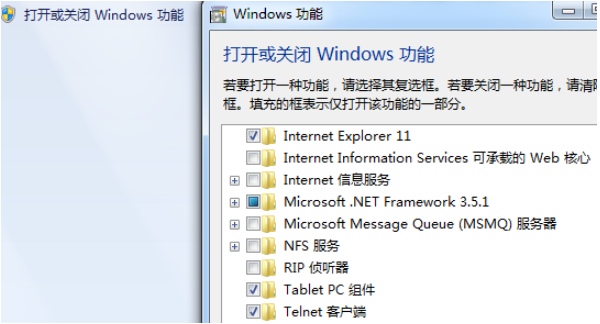

In [31]:
import telnetlib
ifValid=False
for r in ipDataFrame.index:
    try:
        telnetlib.Telnet(ipDataFrame.at[r,'IP Address'], ipDataFrame.at[r,'Port'], timeout=2)
        print(ipDataFrame.at[r,'IP Address']+ ": "+ipDataFrame.at[r,'Port'])
        availableIPportDF=availableIPportDF.append(ipDataFrame.iloc[r])
    except:
        ifValid=False
        
availableIPportDF       

111.29.3.194: 8080
111.29.3.191: 80
183.234.241.105: 8118
111.29.3.223: 80
111.29.3.184: 8080
222.66.94.130: 80
117.93.133.157: 61234
111.29.3.224: 8080
111.29.3.187: 80
47.106.216.42: 8000
149.129.98.81: 80
36.25.243.51: 80
218.104.61.246: 9000
111.29.3.185: 8080
47.107.175.190: 8000
111.29.3.193: 80
111.29.3.221: 8080
124.156.108.71: 82
114.234.214.48: 61234
39.137.69.6: 8080
222.94.163.149: 8118
121.224.191.154: 61234
221.178.232.130: 8080
36.7.89.233: 8060
218.104.61.242: 9000
180.118.128.167: 9000
119.180.169.30: 8060
111.29.3.192: 8080
183.165.30.156: 61234
119.146.131.186: 8118
218.104.61.245: 9000
118.122.114.249: 9000
150.109.55.190: 83
114.234.207.56: 61234
47.106.140.89: 8080
222.189.247.213: 9999
125.105.109.225: 61234
120.83.106.92: 9999
113.64.147.78: 8118
180.168.13.26: 8000
150.109.60.185: 8888
39.137.107.98: 8080
101.231.104.82: 80
183.163.36.65: 61234
47.103.40.244: 8080
120.78.68.241: 3128
183.245.98.6: 8118
118.180.166.195: 8060
117.90.137.84: 9000
120.79.212.174: 8

,IP Address,Port,Protocol,Anonymity,Available,Country,Location,Response(ms),Speed(KB/s),Update(hours ago)
0,111.29.3.194,8080,HTTP,High anonymity,89.7%,"China, CN","Hainan, Qionghai",963,NaN,6
1,111.29.3.191,80,HTTP,High anonymity,100%,"China, CN","Hainan, Qionghai",966,NaN,9
0,111.29.3.194,8080,HTTP,High anonymity,89.7%,"China, CN","Hainan, Qionghai",963,NaN,6
1,111.29.3.191,80,HTTP,High anonymity,100%,"China, CN","Hainan, Qionghai",966,NaN,9
2,183.234.241.105,8118,HTTP,High anonymity,82.7%,"China, CN","Guangdong, Shenzhen",1009,NaN,9
3,111.29.3.223,80,HTTP,High anonymity,100%,"China, CN","Hainan, Qionghai",1030,NaN,8
4,111.29.3.184,8080,HTTP,High anonymity,94.9%,"China, CN","Hainan, Qionghai",1042,NaN,10
6,222.66.94.130,80,HTTP,High anonymity,97.5%,"China, CN","Shanghai, Shanghai",1080,NaN,6
8,117.93.133.157,61234,HTTP,High anonymity,63.2%,"China, CN","Jiangsu, Nanjing",1088,NaN,11
10,111.29.3.224,8080,HTTP,High anonymity,80.4%,"China, CN","Hainan, Qionghai",1098,NaN,8


In [32]:
availIPportDF=availableIPportDF.reset_index(drop=True)
availIPportDF

,IP Address,Port,Protocol,Anonymity,Available,Country,Location,Response(ms),Speed(KB/s),Update(hours ago)
0,111.29.3.194,8080,HTTP,High anonymity,89.7%,"China, CN","Hainan, Qionghai",963,NaN,6
1,111.29.3.191,80,HTTP,High anonymity,100%,"China, CN","Hainan, Qionghai",966,NaN,9
2,111.29.3.194,8080,HTTP,High anonymity,89.7%,"China, CN","Hainan, Qionghai",963,NaN,6
3,111.29.3.191,80,HTTP,High anonymity,100%,"China, CN","Hainan, Qionghai",966,NaN,9
4,183.234.241.105,8118,HTTP,High anonymity,82.7%,"China, CN","Guangdong, Shenzhen",1009,NaN,9
5,111.29.3.223,80,HTTP,High anonymity,100%,"China, CN","Hainan, Qionghai",1030,NaN,8
6,111.29.3.184,8080,HTTP,High anonymity,94.9%,"China, CN","Hainan, Qionghai",1042,NaN,10
7,222.66.94.130,80,HTTP,High anonymity,97.5%,"China, CN","Shanghai, Shanghai",1080,NaN,6
8,117.93.133.157,61234,HTTP,High anonymity,63.2%,"China, CN","Jiangsu, Nanjing",1088,NaN,11
9,111.29.3.224,8080,HTTP,High anonymity,80.4%,"China, CN","Hainan, Qionghai",1098,NaN,8


Use the website(http://icanhazip.com) to test ip

proxy = {

        'http': 'http://' + ip + ':' + port, #access the http website (pairing with your protocol http)
        
        'https': 'https://' + ip + ':' + port #access the https website(pairing with your protocol http)
        
}

In [33]:
import requests

In [35]:
avail2IPportDF= pd.DataFrame(columns=ipDataFrame.columns.values)  # create a empty dataframe with columnNames

header = {'UserAgent':"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.100 Safari/537.36",
          'Connection':'close'#'keep-alive'
         }
proxy={} #dict
for r in availIPportDF.index:
    proxy[availIPportDF.at[r,'Protocol'].lower()] = availIPportDF.at[r,'Protocol'].lower() + "://" +\
                                                    availIPportDF.at[r,'IP Address'] + ":" +\
                                                    availIPportDF.at[r,'Port']
    attempts=0
    success=False
    while attempts <1 and success==False: 
        try:#Note: try is not just one time
            attempts+=1
            page = requests.get('http://icanhazip.com', headers=header, proxies=proxy)
            
            #from lxml import etree
            #page.text='165.22.45.183\n'
            #currentIp=165.22.45.183
            currentIP=re.findall(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b',page.text)[0]
            if currentIP == availIPportDF.at[r,'IP Address'] :
                success=True
                #print("current IP: "+currentIP)

                #print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        except:#Maximum number of open connections reached.
                #OR
                #<title>ERROR:The requested URL could not be retrieved</title>
                #OR
                #ERR_PROXY_CONNECTION_FAILED
            success=False
            attempts+=1
            #print("current IP: "+currentIP+" fail!")
            #current IP: 191.96.42.82 has been attended to the avail2IPportDF
            #current IP: 191.96.42.82 fail!
            #[~]drop the current IP if the current IP in the new dataframe
            avail2IPportDF=avail2IPportDF[~avail2IPportDF['IP Address'].isin([currentIP])]
                
            #print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            break
        else:
            avail2IPportDF=avail2IPportDF.append(availIPportDF.loc[r])
            #avail2IPportDF.append(availIPportDF.loc[0])
            #go to use next ip
        #sleep(2)

In [36]:
avail2IPportDF

,IP Address,Port,Protocol,Anonymity,Available,Country,Location,Response(ms),Speed(KB/s),Update(hours ago)
0,111.29.3.194,8080,HTTP,High anonymity,89.7%,"China, CN","Hainan, Qionghai",963,NaN,6
1,111.29.3.191,80,HTTP,High anonymity,100%,"China, CN","Hainan, Qionghai",966,NaN,9
2,111.29.3.194,8080,HTTP,High anonymity,89.7%,"China, CN","Hainan, Qionghai",963,NaN,6
3,111.29.3.191,80,HTTP,High anonymity,100%,"China, CN","Hainan, Qionghai",966,NaN,9
4,183.234.241.105,8118,HTTP,High anonymity,82.7%,"China, CN","Guangdong, Shenzhen",1009,NaN,9
5,111.29.3.223,80,HTTP,High anonymity,100%,"China, CN","Hainan, Qionghai",1030,NaN,8
6,111.29.3.184,8080,HTTP,High anonymity,94.9%,"China, CN","Hainan, Qionghai",1042,NaN,10
7,222.66.94.130,80,HTTP,High anonymity,97.5%,"China, CN","Shanghai, Shanghai",1080,NaN,6
9,111.29.3.224,8080,HTTP,High anonymity,80.4%,"China, CN","Hainan, Qionghai",1098,NaN,8
10,111.29.3.187,80,HTTP,High anonymity,100%,"China, CN","Hainan, Qionghai",1114,NaN,12


use website https://www.ipip.net/ip.html to test ip again since
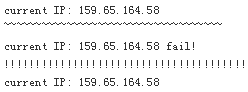

In [37]:
import urllib.request
from lxml import etree

domain='https://en.ipip.net/ip/'

avail2IPportDF=avail2IPportDF.reset_index(drop=True)

for index in avail2IPportDF.index:
    currentIP = avail2IPportDF.at[index,'IP Address']
    currentPort = avail2IPportDF.at[index,'Port']
    currentProtocol = avail2IPportDF.at[index,'Protocol']
    
    proxyStr='{}:{}'.format(currentIP,currentPort)
    proxyDict={}
    proxyDict[currentProtocol]=proxyStr
    proxy_support = urllib.request.ProxyHandler(proxyDict)
    opener = urllib.request.build_opener(proxy_support)
    opener.addheaders = [('User-Agent','Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.100 Safari/537.36')]

    #req = urllib.request.Request(url)
    #response = opener.open(req)
    #OR
    urllib.request.install_opener(opener)
    response = urllib.request.urlopen(domain + currentIP + '.html')

    html = response.read().decode('utf-8')
    from lxml import etree

    selector = etree.HTML(html)
    ip = selector.xpath('//a[contains(@style,"color: #000;")]/text()')[0]
    location = selector.xpath('//td[contains(text(),"Location")]/../td[2]/span/text()')[0]
    
    if(ip==currentIP):
        if pd.isnull(avail2IPportDF.at[index,'Location']):
            print(currentIP + ":" + avail2IPportDF.at[index,'Country'])
        else:    
            print(currentIP + ":" + avail2IPportDF.at[index,'Country'] + ',' + avail2IPportDF.at[index,'Location'])
        print("              "+location)
    else:
        print('False')
        

111.29.3.194:China, CN,Hainan, Qionghai
              China Hainan Haikou
111.29.3.191:China, CN,Hainan, Qionghai
              China Hainan Haikou
111.29.3.194:China, CN,Hainan, Qionghai
              China Hainan Haikou
111.29.3.191:China, CN,Hainan, Qionghai
              China Hainan Haikou
183.234.241.105:China, CN,Guangdong, Shenzhen
              China Guangdong Jieyang
111.29.3.223:China, CN,Hainan, Qionghai
              China Hainan Haikou
111.29.3.184:China, CN,Hainan, Qionghai
              China Hainan Haikou
222.66.94.130:China, CN,Shanghai, Shanghai
              China Shanghai Shanghai
111.29.3.224:China, CN,Hainan, Qionghai
              China Hainan Haikou
111.29.3.187:China, CN,Hainan, Qionghai
              China Hainan Haikou
47.106.216.42:China, CN,Zhejiang, Hangzhou
              China Guangdong Shenzhen
149.129.98.81:China, CN
              China Hong Kong
36.25.243.51:China, CN,Zhejiang, Huzhou
              China Zhejiang Huzhou
218.104.61.246:China, CN
      

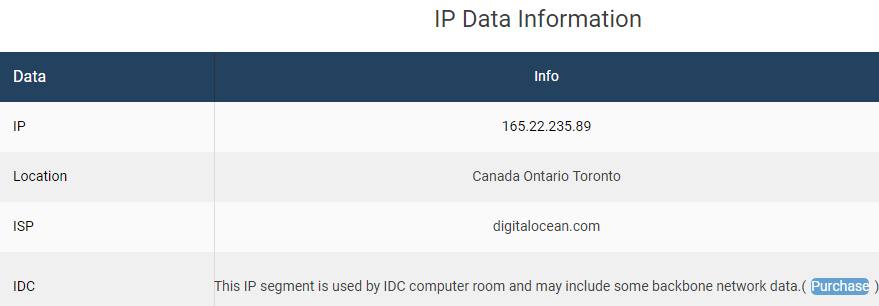

"High anonymity" means:
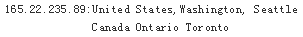

# I find that the result(location) in some ip address is different with IP location in my dataset/dataframe

# Besides, using different ip locator(such as baidu.com) will display another different ip address(112.213.104.1) and location after setting up ip(165.22.235.89) proxy

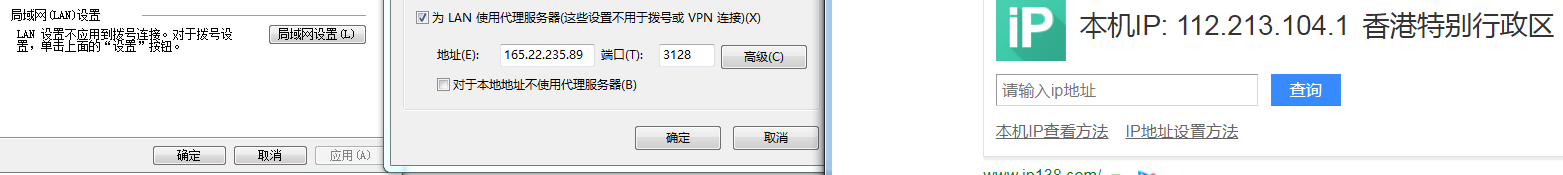

In [32]:
import urllib.request
import random

url = 'https://en.ipip.net/ip/191.96.42.184.html'
iplist = ['191.96.42.184:3129']

proxy_support = urllib.request.ProxyHandler({'http':random.choice(iplist)})

opener = urllib.request.build_opener(proxy_support)
opener.addheaders = [('User-Agent','Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.100 Safari/537.36')]

#req = urllib.request.Request(url)
#response = opener.open(req)
#OR
urllib.request.install_opener(opener)
response = urllib.request.urlopen(url)

html = response.read().decode('utf-8')
from lxml import etree

selector = etree.HTML(html)
ip = selector.xpath('//a[contains(@style,"color: #000;")]/text()')[0]
location = selector.xpath('//td[contains(text(),"Location")]/../td[2]/span/text()')[0]
print(location)

United States Illinois Chicago
